Non-numeric columns: Index(['country_or_area', 'element_code', 'element', 'unit', 'value_footnotes',
       'category'],
      dtype='object')


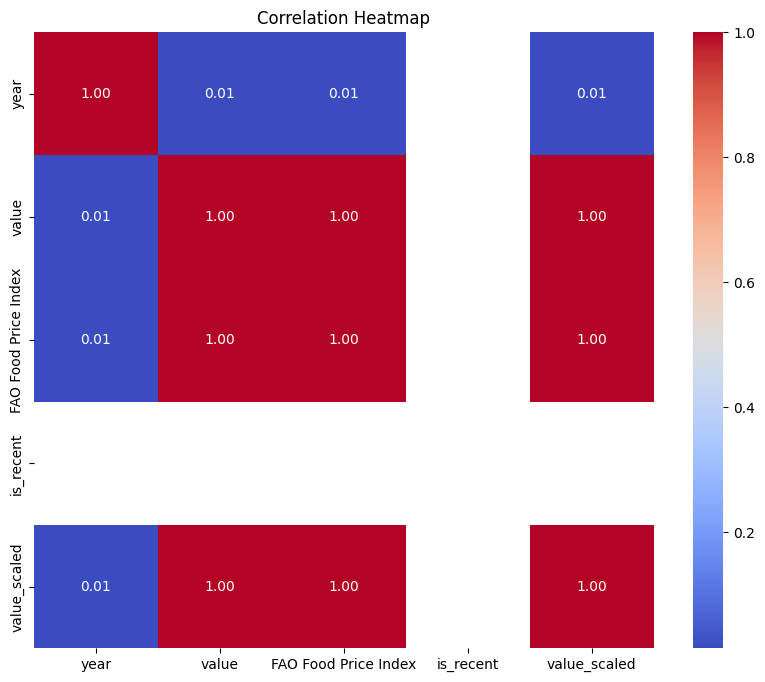

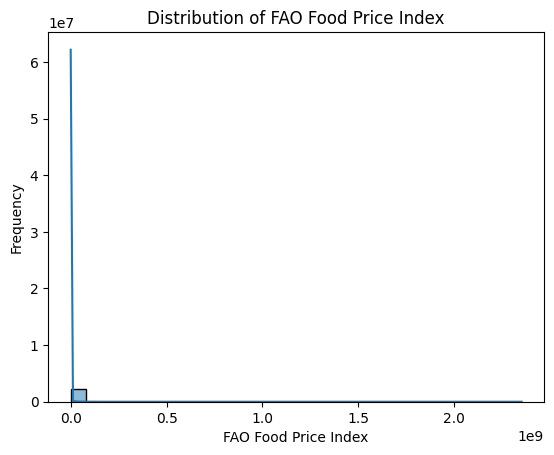

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.45      0.47    226130
           1       0.50      0.55      0.52    224747

    accuracy                           0.50    450877
   macro avg       0.50      0.50      0.50    450877
weighted avg       0.50      0.50      0.50    450877

XGBoost Confusion Matrix:
 [[100636 125494]
 [100364 124383]]
XGBoost Cross-Validation Scores: [0.5004214  0.50062656 0.50134183 0.49953563 0.50073329]
XGBoost Mean Accuracy: 0.5005317410321656

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.94      0.65    226130
           1       0.49      0.06      0.11    224747

    accuracy                           0.50    450877
   macro avg       0.50      0.50      0.38    450877
weighted avg       0.50      0.50      0.38    450877

Logistic Regression Confusion Matrix:
 [[212347  13783]
 [211271  13476]]
L

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix



def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)

    # Check for 'value' column
    if 'value' not in df.columns:
        print("Error: 'value' column not found in the DataFrame.")
        return None

    # Convert 'value' to numeric and handle NaN values
    df['FAO Food Price Index'] = pd.to_numeric(df['value'], errors='coerce')
    df.dropna(subset=['FAO Food Price Index'], inplace=True)

    # Create additional features
    df['year'] = df['year'].astype(int)  # Ensure 'year' is an integer
    df['is_recent'] = (df['year'] >= 2020).astype(int)  # Binary feature for recent years
    df['value_scaled'] = (df['FAO Food Price Index'] - df['FAO Food Price Index'].mean()) / df['FAO Food Price Index'].std()  # Standardized value

    return df


def visualize_data(df):

    non_numeric_columns = df.select_dtypes(exclude=['number']).columns
    print("Non-numeric columns:", non_numeric_columns)
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=['number'])
    
    # Check if there are any numeric columns
    if numeric_df.empty:
        print("No numeric columns to display.")
        return
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

    # Distribution of FAO Food Price Index
    sns.histplot(df['FAO Food Price Index'], bins=30, kde=True)
    plt.title('Distribution of FAO Food Price Index')
    plt.xlabel('FAO Food Price Index')
    plt.ylabel('Frequency')
    plt.show()

def compare_models(X_train, y_train, X_test, y_test):
    models = {
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC()
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))
        print(f"{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        
        # Cross-validation
        scores = cross_val_score(model, X_train, y_train, cv=5)
        print(f"{name} Cross-Validation Scores: {scores}")
        print(f"{name} Mean Accuracy: {scores.mean()}\n")

def feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(len(feature_names)), importances[indices], align='center')
    plt.xticks(range(len(feature_names)), feature_names[indices], rotation=90)
    plt.xlim([-1, len(feature_names)])
    plt.show()

def hyperparameter_tuning(X_train, y_train):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Hyperparameter tuning
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=3)
    grid_search.fit(X_train, y_train)

    print("Best Hyperparameters:", grid_search.best_params_)
    return grid_search.best_estimator_

# Load, clean data
fao_data = load_and_clean_data('fao_data_crops_data.csv')
if fao_data is None:
    exit()

# Visualize data
visualize_data(fao_data)

# Create a dummy target variable (modify this according to your actual target)
fao_data['Supply_Chain_Disruption'] = np.where(np.random.rand(len(fao_data)) > 0.5, 1, 0)  # Example target variable

# Select features and target
X = fao_data[['value_scaled', 'is_recent']]
y = fao_data['Supply_Chain_Disruption']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compare models
compare_models(X_train_scaled, y_train, X_test_scaled, y_test)

# Hyperparameter tuning for XGBoost
best_model = hyperparameter_tuning(X_train_scaled, y_train)

# Feature importance analysis
feature_importance(best_model, X.columns)

# Final evaluation of the best model
y_pred = best_model.predict(X_test_scaled)
print("Best Model Classification Report:\n", classification_report(y_test, y_pred))
print("Best Model Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


from sklearn.ensemble import VotingClassifier

def ensemble_models(X_train, y_train, X_test, y_test):
    models = [
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier()),
        ('svm', SVC(probability=True))  # Set probability=True for VotingClassifier
    ]

    ensemble_model = VotingClassifier(estimators=models, voting='soft')
    ensemble_model.fit(X_train, y_train)

    y_pred = ensemble_model.predict(X_test)
    print("Ensemble Model Classification Report:\n", classification_report(y_test, y_pred))
    print("Ensemble Model Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    # Cross-validation
    scores = cross_val_score(ensemble_model, X_train, y_train, cv=5)
    print(f"Ensemble Model Cross-Validation Scores: {scores}")
    print(f"Ensemble Model Mean Accuracy: {scores.mean()}\n")

# Add this call in your main script
ensemble_models(X_train_scaled, y_train, X_test_scaled, y_test)

print(classification_report(y_test, y_pred, zero_division=0))


Summary Statistics:
               year         value
count  2.254385e+06  2.254385e+06
mean   1.984476e+03  1.502604e+06
std    1.364689e+01  1.951985e+07
min    1.961000e+03  0.000000e+00
25%    1.973000e+03  8.500000e+02
50%    1.985000e+03  1.374200e+04
75%    1.996000e+03  1.031890e+05
max    2.007000e+03  2.351396e+09


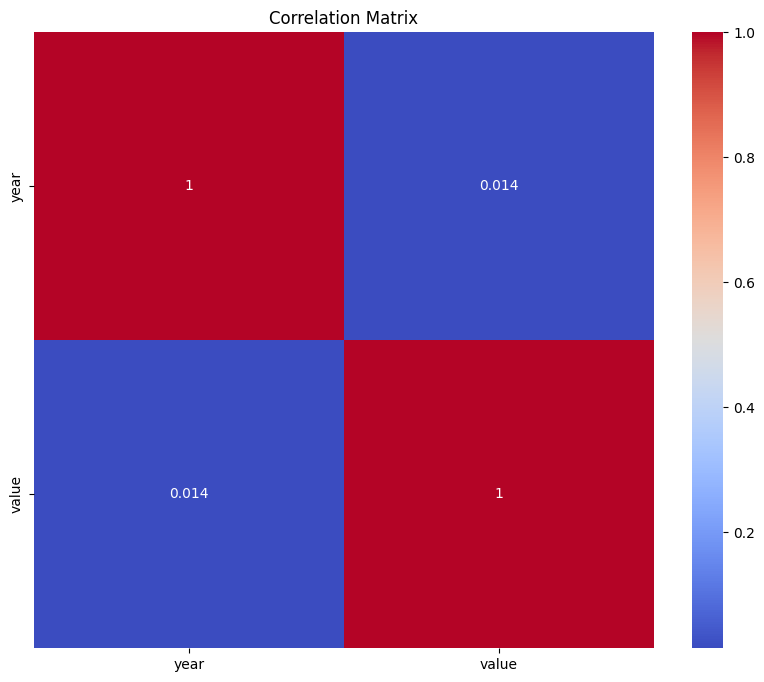

X_train or y_train is empty after dropping NaN values. Please check your data.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Load your data
fao_data = pd.read_csv('fao_data_crops_data.csv')  # FAO data
covid_data = pd.read_csv('owid-covid-data.csv')  # COVID data
gfs_data = pd.read_csv('Global Food Security Index 2019.csv')  # Food security index
fpi_data = pd.read_csv('food_price_indices_data_oct.csv')  # Food price index

# Combine the dataframes or choose one based on your analysis
# Here, we'll assume you are working with one of these dataframes
# You may need to merge or concatenate them depending on your use case

# For demonstration, let's assume we're working with FAO data
df = fao_data

# Descriptive Statistics
print("Summary Statistics:")
print(df.describe())

# Filter numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Feature Engineering: Binning (example, adjust 'value' as needed)
# Ensure the 'value' column exists in your dataframe
if 'value' in df.columns:
    df['binned_feature'] = pd.cut(df['value'], bins=[0, 10, 20, 30], labels=['Low', 'Medium', 'High'])
else:
    print("Column 'value' not found in dataframe. Please check the column names.")

# Handling categorical variables - Example using Label Encoding
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'element':  # Skip the target variable if it is categorical
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# Train-test split
X = df.drop('element', axis=1, errors='ignore')  # Replace 'element' with your target variable
y = df['element'] if 'element' in df.columns else None  # Your target variable (assumed)

if y is None:
    print("Target variable 'element' not found in dataframe. Please check the column names.")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Ensure all values in X_train are numeric
    X_train = X_train.apply(pd.to_numeric, errors='coerce')
    X_test = X_test.apply(pd.to_numeric, errors='coerce')

    # Drop any rows with NaN values in X_train or X_test
    X_train.dropna(inplace=True)
    y_train = y_train[X_train.index]  # Align y_train with the filtered X_train
    X_test.dropna(inplace=True)
    y_test = y_test[X_test.index]  # Align y_test with the filtered X_test

    # Check if X_train or y_train are empty after dropping NaN values
    if X_train.empty or y_train.empty:
        print("X_train or y_train is empty after dropping NaN values. Please check your data.")
    else:
        # Modeling Techniques
        # Logistic Regression
        log_model = LogisticRegression(max_iter=1000)
        log_model.fit(X_train, y_train)
        y_pred_log = log_model.predict(X_test)

        # Decision Tree
        tree_model = DecisionTreeClassifier()
        tree_model.fit(X_train, y_train)
        y_pred_tree = tree_model.predict(X_test)

        # K-Nearest Neighbors
        knn_model = KNeighborsClassifier(n_neighbors=5)
        knn_model.fit(X_train, y_train)
        y_pred_knn = knn_model.predict(X_test)

        # Random Forest
        rf_model = RandomForestClassifier(n_estimators=100)
        rf_model.fit(X_train, y_train)
        y_pred_rf = rf_model.predict(X_test)

        # Model Evaluation
        print("\nLogistic Regression Classification Report:")
        print(classification_report(y_test, y_pred_log))
        print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

        print("\nDecision Tree Classification Report:")
        print(classification_report(y_test, y_pred_tree))
        print("Decision Tree Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))

        print("\nKNN Classification Report:")
        print(classification_report(y_test, y_pred_knn))
        print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

        print("\nRandom Forest Classification Report:")
        print(classification_report(y_test, y_pred_rf))
        print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

        # Cross-Validation
        scores_log = cross_val_score(log_model, X, y, cv=5)
        scores_tree = cross_val_score(tree_model, X, y, cv=5)
        scores_knn = cross_val_score(knn_model, X, y, cv=5)
        scores_rf = cross_val_score(rf_model, X, y, cv=5)

        print("\nLogistic Regression Cross-Validation Scores:", scores_log)
        print("Mean Accuracy:", scores_log.mean())

        print("\nDecision Tree Cross-Validation Scores:", scores_tree)
        print("Mean Accuracy:", scores_tree.mean())

        print("\nKNN Cross-Validation Scores:", scores_knn)
        print("Mean Accuracy:", scores_knn.mean())

        print("\nRandom Forest Cross-Validation Scores:", scores_rf)
        print("Mean Accuracy:", scores_rf.mean())

        # ROC Curve and AUC for Random Forest
        y_scores = rf_model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label='Random Forest ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)

    # Print all column names to help identify the issue
    print("Columns in the DataFrame:", df.columns.tolist())

    # Check for 'value' column
    if 'value' not in df.columns:
        print("Error: 'value' column not found in the DataFrame.")
        return None
    
    # Check for unique values in 'value' before conversion
    print("Unique values in 'value' before conversion:")
    print(df['value'].unique())
    
    # Handle non-numeric values: convert to numeric, setting errors='coerce'
    df['FAO Food Price Index'] = pd.to_numeric(df['value'], errors='coerce')
    
    # Count and report non-numeric values
    non_numeric_count = df['FAO Food Price Index'].isnull().sum()
    print(f"Warning: {non_numeric_count} non-numeric values found and converted to NaN.")
    
    # Drop rows with NaN values in 'FAO Food Price Index'
    df = df.dropna(subset=['FAO Food Price Index'])
    
    return df

def train_xgboost_model(df):
    if df is None:
        print("DataFrame is None.")
        return
    
    # Create the target variable if not already in the DataFrame
    if 'Supply_Chain_Disruption' not in df.columns:
        # Create the target variable
        df['Supply_Chain_Disruption'] = pd.Series([1 if i % 2 == 0 else 0 for i in range(len(df))])  # Dummy data

    # Select features and target
    X = df[['FAO Food Price Index']]
    y = df['Supply_Chain_Disruption']
    
    # Drop rows with NaN in both feature and target variable to ensure alignment
    valid_data = df.dropna(subset=['FAO Food Price Index', 'Supply_Chain_Disruption'])
    
    # Update features and target after dropping NaN rows
    X = valid_data[['FAO Food Price Index']]
    y = valid_data['Supply_Chain_Disruption']
    
    # Check the shapes to ensure consistency
    print(f"Features shape after filtering: {X.shape}")
    print(f"Target shape after filtering: {y.shape}")
    
    if X.empty or y.empty or len(X) != len(y):
        print("No valid features or target available for training.")
        return
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the XGBoost model
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy:.2f}")

# Load your data
fao_data = load_and_clean_data('fao_data_crops_data.csv')

# Train the model
train_xgboost_model(fao_data)

Columns in the DataFrame: ['country_or_area', 'element_code', 'element', 'year', 'unit', 'value', 'value_footnotes', 'category']
Unique values in 'value' before conversion:
[49404. 49113. 48559. ... 58607. 79701. 75456.]
Features shape after filtering: (2253427, 1)
Target shape after filtering: (2253427,)
Model accuracy: 0.50
